# **Regresja i klasyfikacja**
# Wykonawca - Levchenko Sofiia

## Wstęp
Na tym ćwiczeniu zajęliśmy się implementacją drzew decyzyjnych tworzonych algorytmem ID3 z ograniczeniem maksymalnej głębokości drzewa. Następnie należało wykorzystać dany algorytm do stworzenia i zbadania jakości klasyfikatora dla danego zbioru (w naszym przypadku to był zbiór *breast cancer*).

### Wykorzystane narzędzia

W celu *implementacji* wyżej wspomnianego algorytmu, zostały wykorzystane pakie biblioteki jak `numpy` oraz `random`.

Pierwsza wspomniana biblioteka pozwala na swobodne posługiwanie się podstawowymi metodami obliczeń numerycznych oraz obsługiwanie tablic i słowników niezbędnych do interpretacji drzewadecyzyjnego, a druga została wykorzystana w celu generowania liczb losowych z pewnego przedziału. 

Kolejne biblioteki, czyli `pandas`, `matplotlib`, `tabulate`, `seaborn` oraz `pprint` zostały wykorzystane do *przetworzenia* otrzymanych wyników (i do załadowania zbioru danych z otrzymanego pliku) oraz ich *wizualizacji* w postaci czytelnej dla człowieka.

In [265]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sn
import pprint

Zanim została zaczęta praca nad implementacją algorytmu, został załadowany zbiór danych z pliku `breast-cancer.txt`, następnie kolejne wierze tego plku zostały pomieszane, również zostały wyrzucone dane o zerowj wartości zysku informacyjnego (chodzi tutaj o przypadek, pascjenci o tych samych parametrach mają różne przydzielonee klasy) oraz zostały wyrzucone wiersze, w których przynajmniej jedna z wartości jest nieznana (w naszym przypadku, jest równa "?").

In [266]:
data = pd.read_csv("breast-cancer.txt", names=["class", "age", "menopause", "tumor-size", "inv-nodes", "node-caps", "deg-malig", "breast", "breast-quad", "irradiat"])
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data = data.drop_duplicates(subset=["class", "age", "menopause", "tumor-size", "inv-nodes", "node-caps", "deg-malig", "breast", "breast-quad"])
data = data[~(data == '?').any(axis=1)]

## Implementacja algorytmu

Aby zaimplementować algorytm, najpierw zostały wprowadzone funkcje pomocnicze do obliczania wartości entropii atrybutu niezależnie od innych atrybutów, czyli **calc_entropy**, też została wprowadzona funkcja do obliczenia entropii atrybutu w zbiorze (aby na jeg podstawie potem dało się obliczyć zysk informacyjny), czyli **calc_entropy_attribute**, jak zostało wspomniano wcześniej, też mamy funkcję, która oblicza zysk informacyjny wszystkich atrybutów i zwraca największy (ten atrybut potem zostaje się liściem w bieżącym drzewie), tą funkcją jest **find_max_gain**. 

### Funkcje pomocnicze do implementacji algorytmu

In [267]:
def calc_entropy(data):
    class_name = data.keys()[-1]  
    entropy = 0
    values = data[class_name].unique()
    for value in values:
        fraction = data[class_name].value_counts()[value]/len(data[class_name])
        entropy += -fraction*np.log2(fraction)
    return entropy

In [268]:
def calc_entropy_attribute(data, attribute):
  class_name = data.keys()[-1]  
  target_variables = data[class_name].unique() 
  features = data[attribute].unique()
  entropy_overall = 0
  eps = np.finfo(float).eps
  for feature in features:
      entropy = 0
      for target_variable in target_variables:
          nominator = len(data[attribute][data[attribute]==feature][data[class_name] ==target_variable])
          denominator = len(data[attribute][data[attribute]==feature])
          fraction = nominator/(denominator+eps)
          entropy += -fraction*np.log2(fraction+eps)
      fraction_overall = denominator/len(data)
      entropy_overall += -fraction_overall*entropy
  return abs(entropy_overall)

In [269]:
def find_max_gain(data):
    info_gain = []
    for key in data.keys()[:-1]:
        info_gain.append(calc_entropy(data)-calc_entropy_attribute(data,key))
    return data.keys()[:-1][np.argmax(info_gain)]

### Funkcja implementująca algorytm ID3 do tworzenia drzewa decyzyjnego

W tej sekcji został zaimplementowany algorytm ID3 (funckja **build_tree**), do którego jest przekazywany zbiór danych które pomagają w trenowaniu naszego modelu, maksymalna głębokość drzewa oraz bieżąca głębokość drzewa decyzyjnego. Również dało by się przekazywać nazwę atrybutu, odpowiadającego za klasę, jednak zostało to zapisane wewnątrz funckji jako `data.keys()[-1]`, wykorzystując założenie, że zawsze atrybut ten będzie w ostaniej kolumnie przekazywanego zbioru. Tak samo się dzieje z wyznaczaniem unikatowych atrybutów dla liścia z największym zyskiem informacyjnym.

In [270]:
def build_tree(data, max_depth, depth=0):
  class_name = data.keys()[-1]
  node = find_max_gain(data)
  attributes = np.unique(data[node])
  tree = {}
  tree[node] = {} 
  for value in attributes:  
    subtable = data[data[node] == value].reset_index(drop=True)
    clValue, counts = np.unique(subtable[class_name],return_counts=True)
    if len(counts)==1:
      tree[node][value] = clValue[0]
    elif int(depth/2) >= max_depth - 1:
      if counts[0] > counts[1]:
        tree[node][value] =  clValue[0] 
      elif counts[0] < counts[1]:
        tree[node][value] =  clValue[1] 
      else:
        tree[node][value] =  clValue[random.randint(0, 1)] 
    else:
      tree[node][value] = build_tree(subtable, max_depth, depth + 2)
  return tree

### Funkcje pomocnicze do testowania algorytmu

Aby później udało się sprawnie przetestować działanie zaimplementowanego algorytmu, zostały wprowadzone kolejne dwie funkcje - **predict_value** do przypisania predykcji klasy oraz **walidate** do przeprowadzeniapredykcji dla każdej wartości z przekazanego zbioru oraz zebrania podstawowych statystyk.


In [271]:
def predict_value(data, tree):
  attr = list(tree.keys())
  value = data[attr].values[0][0]
  if not tree[attr[0]].get(value):
    return "Can't predict value"
  if type(tree[attr[0]][value]) is str:
    return tree[attr[0]][value]
  else: 
    return predict_value(data, tree[attr[0]][value])

In [272]:
def walidate(walidating_set, tree):
  true_negatives = 0
  true_positives = 0
  false_negatives = 0
  false_positives = 0
  cant_predict = 0
  result = []
  for n in range(0, len(walidating_set)): 
    value = predict_value(walidating_set[n:n+1], tree)
    if (value == "yes") and (value == walidating_set[n:n+1].iloc[0]["irradiat"]):
      true_positives+=1
    elif (value == "no") and (value == walidating_set[n:n+1].iloc[0]["irradiat"]):
      true_negatives+=1
    elif (value == "no") and (value != walidating_set[n:n+1].iloc[0]["irradiat"]):
      false_negatives+=1
    elif (value == "yes") and (value != walidating_set[n:n+1].iloc[0]["irradiat"]):
      false_positives+=1
    else:
      cant_predict+=1
    result.append([value, walidating_set[n:n+1].iloc[0]["irradiat"]])
  accuracy = (true_negatives+true_positives)/(true_negatives+true_positives+false_negatives+false_positives)
  array = np.array([true_negatives, true_positives, false_negatives, false_positives, cant_predict]);
  return array, accuracy, result

### Testowanie działania zaimpelementowanych funkcji

Zanim przeszliśmy do etapu walidacji algorytmu i odnajdywania najlepszego zestawu parametrów, algorytm został przetestowany dla podziału 0.7:0.2:0.1 zbioru danych na zbiór trenujący, walidacyjny oraz testowy i dla głębokości drzewa równej 3 została obliczona dokłądność uzyskiwanego wyniku dla zbioru trenującego.

Również zostało pokazane zbudowane drzewo, na podstawie którego były robione predykcje dla wyżej wspomnianego zbioru.

In [278]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
slice_point1 = np.floor(len(data)*0.7).astype(int)
slice_point2 = np.floor(len(data)*0.9).astype(int)
training_set = data.iloc[0:slice_point1, :]
walidating_set = data.iloc[slice_point1 + 1: slice_point2, :]
testing_set = data.iloc[slice_point2 + 1: len(data) - 1, :]
tree = build_tree(training_set, 3)
array, accuracy, result = walidate(training_set, tree)
print("Accuracy: ", accuracy)
print("\nDrzewo decyzyjne:")
pprint.pprint(tree)

Accuracy:  0.9120879120879121

Drzewo decyzyjne:
{'inv-nodes': {'0-2': {'tumor-size': {'0-4': 'no',
                                      '10-14': {'age': {'30-39': 'no',
                                                        '40-49': 'no',
                                                        '50-59': 'no',
                                                        '60-69': 'no'}},
                                      '15-19': {'breast-quad': {'central': 'yes',
                                                                'left_low': 'no',
                                                                'left_up': 'no',
                                                                'right_low': 'no'}},
                                      '20-24': {'deg-malig': {1: 'no',
                                                              2: 'no',
                                                              3: 'no'}},
                                      '25-29': {'class': {'no-recurre

## Ocena jakości algorytmu, dobór hiperparametrów

Kolejnym etapem trenowania naszego modelu, było dobranie właściwych hiperparametrów, które by pozwalały na uzyskanie maksymalnie dużej dokładności uzyskiwanych wyników. 

Aby testowanie przebiegło pomyślnie i nie było uzależnione od tego, jak zostały umieszczone dane w zbiorze, badania (a właściwie tworzenie drzewa decyzyjnego) zostały przeprowadzone po kilka razy, gdzie za każdym razem wierze zbioru zostały pomieszane między sobą.

Zbadany został wpływ takich hiperparametrów jak punkt podziału zbioru danych (w jakim mieejscu dzielimy. zbiór na dane trenujące i dane walidazyjne) oraz głębokość drzewa decyzyjnego (aby uniknąć przeuczania się modelu).

### Definiowanie parametrów do testowania

In [ ]:
slicing_part = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
slicing_part_test = 0.8
depths = [1, 2, 3, 4, 5, 6, 7]
depth = 4
iter = 15

### Ocena wpływu wyboru punktu podziału zbioru danych na podzbiory (liczności zbioru trenującego)

In [ ]:
slice_point2 = np.floor(len(data)*0.9).astype(int)
results_slice = []
tree = None
for i in range(len(slicing_part)):
  part_results = []
  training_set = []
  walidating_set = []
  for j in range(iter):
    slice_point1 = np.floor(len(data)*slicing_part[i]).astype(int)
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    training_set = data.iloc[0:slice_point1, :]
    walidating_set = data.iloc[slice_point1 + 1: slice_point2, :]
    testing_set = data.iloc[slice_point2 + 1: len(data) - 1, :]
    tree = build_tree(training_set, depths[i])
    array1, accuracy1, result1 = walidate(training_set, tree)
    array2, accuracy2, result2 = walidate(walidating_set, tree)
    part_results.append(np.array([accuracy1, accuracy2]));
  results_slice.append(part_results)

In [ ]:
raw_results_train_slice = []
raw_results_walid_slice = []
for i in range(len(results_slice)):
  df = pd.DataFrame(results_slice[i])
  df_res = df.transpose()
  raw_results_train_slice.append(df_res.iloc[1, :])
  raw_results_walid_slice.append(df_res.iloc[0, :])

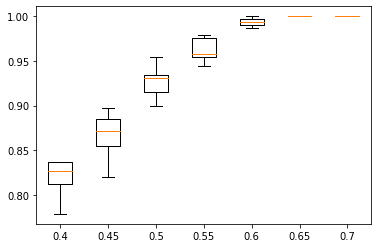

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(raw_results_walid_slice, showfliers=False)
plt.xticks([1,2,3,4,5,6,7], slicing_part)
plt.ylabel("Accuracy")
plt.xlabel("Slicing point")
plt.show()

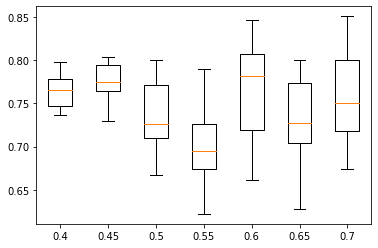

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(raw_results_train_slice, showfliers=False)
plt.xticks([1,2,3,4,5,6,7], slicing_part)
plt.ylabel("Accuracy")
plt.xlabel("Slicing point")
plt.show()

Możemy zauważyć, że dla zbioru danych przeznaczonych dla trenowania, im większy był zbiór danych, tym lepsze były uzyskiwane wyniki (co jest naturalne, jako że im więcej mamy danych, tym większa jest szansa, że dla zostaną wykryte dodatkowe gałęzie drzewa), jednak dla zbioru walidacyjnego szczyt (największa średnia wartość przy. możliwie najmniejszym odchyleniu standardowym) jest osiągany dla wartości bliskiej 0.6.

### Ocena wpływu głębokości drzewa decyzyjnego


In [ ]:
slice_point1 = np.floor(len(data)*0.6).astype(int)
slice_point2 = np.floor(len(data)*0.9).astype(int)
depths = [1,2,3,4,5,6,7]
results_depth = []
for i in range(len(depths)):
  training_set = []
  walidating_set = []
  part_results = []
  for j in range(iter):
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    training_set = data.iloc[0:slice_point1, :]
    walidating_set = data.iloc[slice_point1 + 1: slice_point2, :]
    testing_set = data.iloc[slice_point2 + 1: len(data) - 1, :]
    tree = build_tree(training_set, depths[i])
    array1, accuracy1, result1 = walidate(training_set, tree)
    array2, accuracy2, result2 = walidate(walidating_set, tree)
    part_results.append(np.array([accuracy1, accuracy2]));
  results_depth.append(part_results)

In [ ]:
raw_results_train_depth = []
raw_results_walid_depth = []
for i in range(len(results_depth)):
  df = pd.DataFrame(results_depth[i])
  df_res = df.transpose()
  raw_results_walid_depth.append(df_res.iloc[1, :])
  raw_results_train_depth.append(df_res.iloc[0, :])

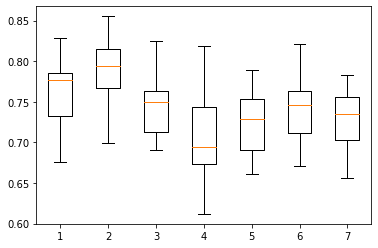

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(raw_results_walid_depth, showfliers=False)
plt.xticks([1,2,3,4,5,6,7], depths)
plt.show()

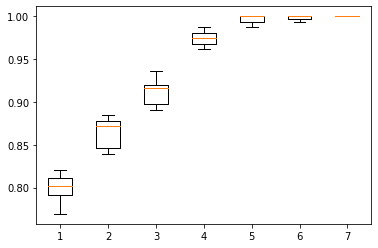

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(raw_results_train_depth, showfliers=False)
plt.xticks([1,2,3,4,5,6,7], depths)
plt.show()

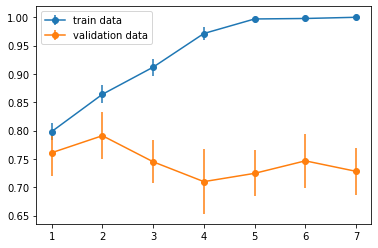

In [ ]:
aggregated_train_values = pd.DataFrame(raw_results_train_depth).transpose().agg([np.mean, np.std])
aggregated_walidation_values = pd.DataFrame(raw_results_walid_depth).transpose().agg([np.mean, np.std])
plt.errorbar(depths, aggregated_train_values.iloc[0, :], yerr=aggregated_train_values.iloc[1, :], fmt='-o', label = "train data")
plt.errorbar(depths, aggregated_walidation_values.iloc[0, :], yerr=aggregated_walidation_values.iloc[1, :], fmt='-o', label = "validation data")
plt.legend()
plt.show()

Możemy zauważyć, że nasz model przeucza się dość szybko - po osiągnięciu wartości głębokości drzewa decyzyjnego równej 2, dokłądność uzyskiwanego wyniku w przypadku zbioru walidacyjnego już nigdy nie osiąga dokłądności rzędu 0.8, chociaż i dalej znajduje się w zakresie 0.65-0.75.

## Testowanie algorytmu
Na tym etapie, jako już zostały wyznaczone wystarczająco dobre wartości hiperparametrów - 0.6 jako punkt podziału zbioru oraz 2 jako głębokość drzewa decyzyjnego, nasz model zostanie przetestowany dla wszystkich trzech zbiorów - trenującego, walidacyjnego i testowego. Zostaną obliczone wartości takich metryk jak *accuracy*, *precision* oraz *recall*. Jedynie dla zbioru testującego zostanie zbudowany *confusion matrix*.

- Precision - the fraction of positive cases correctly identified (the number of true positives divided by the number of true positives plus false positives) (out of all the patients that the model predicted as having breast cancer, how many are actually have it)
- Recall - the fraction of the cases classified as positive that are actually positive (the number of true positives divided by the number of true positives plus false negatives) (out of all the patients who actually have breast cancer, how many did the model identify)

In [378]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
slice_point1 = np.floor(len(data)*0.6).astype(int)
slice_point2 = np.floor(len(data)*0.9).astype(int)
training_set = data.iloc[0:slice_point1, :]
walidating_set = data.iloc[slice_point1 + 1: slice_point2, :]
testing_set = data.iloc[slice_point2 + 1: len(data) - 1, :]

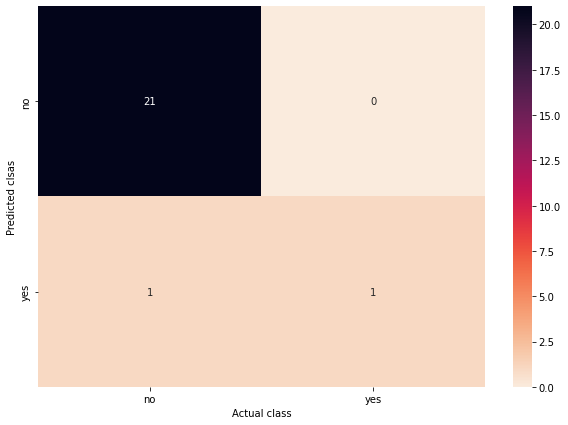

In [377]:
tree = build_tree(training_set, 2)
array_train, accuracy_train, result_train = walidate(training_set, tree)
array_valid, accuracy_valid, result_valid = walidate(walidating_set, tree)
array_test, accuracy_test, result_test = walidate(testing_set, tree)
new_array = [[array_test[0], array_test[2]],
             [array_test[3], array_test[1]]]
df_cm = pd.DataFrame(new_array, index = ["no", "yes"],
                  columns = ["no", "yes"])
plt.figure(figsize = (10, 7))
cmap = sn.cm.rocket_r
sn.heatmap(df_cm, annot=True, cmap=cmap)
plt.ylabel("Predicted clsas")
plt.xlabel("Actual class")
plt.show()

In [379]:
result_computed = [
                   ["Training", np.floor(accuracy_train*100), np.floor(array_train[1]*100/(array_train[1]+array_train[3])), np.floor(array_train[1]*100/(array_train[1]+array_train[2])), np.floor(array_train[4]*100/len(result_train)) ],
                   ["Validation", np.floor(accuracy_valid*100), np.floor(array_valid[1]*100/(array_valid[1]+array_valid[3])), np.floor(array_valid[1]*100/(array_valid[1]+array_valid[2])), np.floor(array_valid[4]*100/len(result_valid)) ],
                   ["Testing", np.floor(accuracy_test*100), np.floor(array_test[1]*100/(array_test[1]+array_test[3])), np.floor(array_test[1]*100/(array_test[1]+array_test[2])), np.floor(array_test[4]*100/len(result_test)) ]
]
print(tabulate(result_computed, headers=['Dataset', 'Acurracy [%]', 'Precision [%]', "Recall [%]", "Unknown Values [%]"], tablefmt="fancy_grid"))

╒════════════╤════════════════╤═════════════════╤══════════════╤══════════════════════╕
│ Dataset    │   Acurracy [%] │   Precision [%] │   Recall [%] │   Unknown Values [%] │
╞════════════╪════════════════╪═════════════════╪══════════════╪══════════════════════╡
│ Training   │             85 │              84 │           44 │                    0 │
├────────────┼────────────────┼─────────────────┼──────────────┼──────────────────────┤
│ Validation │             71 │              30 │           17 │                    3 │
├────────────┼────────────────┼─────────────────┼──────────────┼──────────────────────┤
│ Testing    │             95 │              50 │          100 │                    4 │
╘════════════╧════════════════╧═════════════════╧══════════════╧══════════════════════╛


Możemy zauważyć, że wartości wszystkich zdefiniowanych metryk, uzyskiwanych dla zbiory testującego (w danym przypadku) są dość dobre jak dla algorytmu typu ID3. 

## Przykładowe drzewo decyzyjne

In [ ]:
print("Decision tree: ")
pprint.pprint(tree)

Decision tree: 
{'inv-nodes': {'0-2': {'tumor-size': {'0-4': 'no',
                                      '10-14': 'no',
                                      '15-19': 'no',
                                      '20-24': 'no',
                                      '25-29': 'no',
                                      '30-34': 'no',
                                      '35-39': 'no',
                                      '40-44': 'no',
                                      '45-49': 'yes',
                                      '5-9': 'yes',
                                      '50-54': 'no'}},
               '12-14': 'yes',
               '15-17': {'tumor-size': {'15-19': 'no',
                                        '30-34': 'no',
                                        '35-39': 'no',
                                        '40-44': 'yes'}},
               '3-5': {'age': {'30-39': 'yes',
                               '40-49': 'yes',
                               '50-59': 'no',
       

Warto zauważyć, że drzewo decyzyjne z większym prawdopodobieństwem wykryje osób, które nie maką onkologii, niż tych osób które ją mają z powodu tego, że zbior danych na których trenujemy nasz model jest dość mały, a przypadków pozytywnych jest o wiele mniej niż przypadków negatywnych.

## Wnioski i obserwacje

Zaimplementowany aklgorytm cechuje się tendencją do przeuczania się, zatem dość poważnie trzeba podejść do doboru właściwych parametrów, aby algorytm był w stanie dość dobrze działać na danych testowych.

Niestety ten algorytm, i zbudowane z jego pomocą drzewo decyzyjne nie jest w stanie przewidywać wynik dla zbioru, który zawiera dane, nieobecne w danym drzewie decyzyjnym (w przypadku niektórych liści).

Dość ciekawym spostrzeżeniem było to, że punkt podziału zbioru danych jest dość istotnym parametrym, jeżeli chodzi o trenowanie modeli z wykorzystaniem drzew decyzyjnych. 

Dość ciekawym jest to, że uzyskiwane wartości metryk (wykorzystywanych do oceny algorytmów klasyfikacji) nie są zbytnio skorelowane ze sobą (jeżeli chodzi o porównanie wyniku dla zbioru trenującego, walidacyjnego i testującego), chociaż też to pewnie tak się dzieje z powodu nie wystarczająco licznej i dokładnej (Wartości nie mające sens, o których mowa była na samym początku) próbki badanych danych.